## Ilinois Basin data preliminary analysis

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.data_preparation import Catalogue
from tqdm import tqdm
import os
import pickle
from src.clustering_module import ScipyHierarchy, EvaluateClustering
import src.plotting_geo
import seaborn as sns


### Data analysis

Load data

In [2]:
raw_catalogue = pd.read_excel(r'../data/illinois_basin/data/DD_relocations_catalogue_20200428_regionletters_95pcnt_confidence.xlsx', sheet_name='Local_crs_metres', index_col=[0])

The 'latitude' 'longitude' are in reality relative northing/easting positions, we rename them for easier use of legacy functions

In [3]:
reduced_catalogue = raw_catalogue[['SLB origin time', 'SLB northing (m)', 'SLB easting (m)', 'SLB depth (m)', 'SLB magnitude (Mw)']].copy()
reduced_catalogue = reduced_catalogue.rename(columns={'SLB origin time':'event_time', 'SLB northing (m)':'latitude', 'SLB easting (m)': 'longitude', 'SLB depth (m)': 'depth', 'SLB magnitude (Mw)':'magnitude'})
reduced_catalogue.head()

,event_time,latitude,longitude,depth,magnitude
NORSAR_ID,,,,,
2636,2012-10-07 21:42:31.324,1613.611,-1833.372,2213.762,-0.34
2647,2012-10-09 05:30:48.846,1621.536,-1820.875,2207.971,-0.54
3921,2013-09-15 23:05:32.826,1600.505,-1835.201,2194.560,0.13
2664,2012-10-10 14:34:42.771,1585.265,-1848.612,2208.276,-0.67
3911,2013-09-15 19:55:27.488,1581.912,-1842.211,2201.875,0.25


Check boundaries of the dataset and set the cube dimentions

In [4]:
print(reduced_catalogue.event_time.min(), reduced_catalogue.event_time.max())
print(f'Latitude: {reduced_catalogue.latitude.min()} to {reduced_catalogue.latitude.max()}')
print(f'Longitude: {reduced_catalogue.longitude.min()} to {reduced_catalogue.longitude.max()}')
print(f'Depth: {reduced_catalogue.depth.min()} to {reduced_catalogue.depth.max()}')

2011-12-15 00:57:20.746000 2018-07-02 00:39:13.613000
Latitude: -893.064 to 2214.982
Longitude: -2252.472 to 1204.57
Depth: 1834.896 to 2271.065


In [5]:
geo_bounds = {'lat_min': -2000,
            'lat_max': 2000,
            'long_min': -2000,
            'long_max': 2000,
            'depth_min': 1500,
            'depth_max': 2500,
            'step_l': 200,
            'step_d': 200}


# Change the depth step to 200m, recreate again the catalogues and share them
# Test some lower thresholds for clustering to achieve more clusters and compare them

Create the catalogue class, index cubes with their id of lat long depth

In [6]:
data_catalogue = Catalogue(catalogue = reduced_catalogue, geo_bounds=geo_bounds)
data_catalogue.index_cubes()

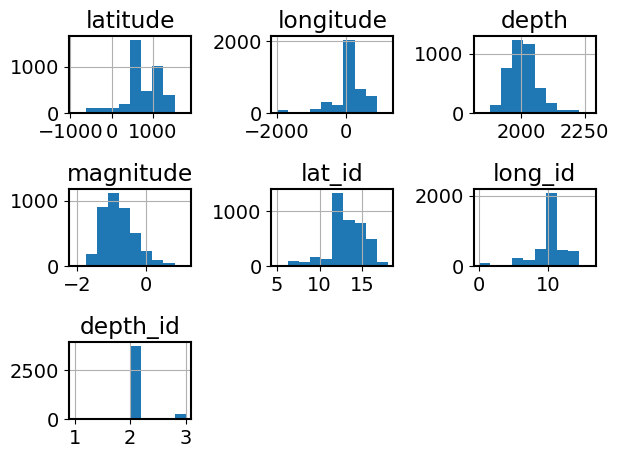

In [7]:
data_catalogue.reduced_catalogue[['latitude', 'longitude', 'depth', 'magnitude', 'lat_id', 'long_id', 'depth_id']].hist()
plt.tight_layout()

### Time series and distance matrix preparation

Index 1D of all the cubes, the 1D index is a combination of the respective lat long depth ids.

In [8]:
def index_1d(row:pd.Series, max_lat:int, max_long:int) -> int:
    #Retrun index
    return int(row['lat_id'] + max_lat * row['long_id'] + max_lat * max_long * row['depth_id'])

- df_density

In [9]:
# start_date = data_catalogue.reduced_catalogue.event_time.min()

# data_catalogue.reduced_catalogue['day_id'] = reduced_catalogue.apply(lambda row: int((row.event_time-start_date).days // 3), axis=1)
# df_density = data_catalogue.compile_dataset_days()

- time_series and df_density loop for different values of time_range (now commented as the results are saved)

In [10]:
distance_matrices = []
time_ranges = [10, 30, 60]
folder_path_dm = r'..\data\illinois_basin\clustering_evaluation\distance_matrix'
folder_path_ts = r'..\data\illinois_basin\clustering_evaluation\time_series'

for t, time_range in enumerate(time_ranges):
    start_date = data_catalogue.reduced_catalogue.event_time.min()
    data_catalogue.reduced_catalogue['year'] = reduced_catalogue.apply(lambda row: row.event_time.year, axis=1)
    data_catalogue.reduced_catalogue['month'] = reduced_catalogue.apply(lambda row: row.event_time.month, axis=1)
    data_catalogue.reduced_catalogue['day_id'] = reduced_catalogue.apply(lambda row: int((row.event_time-start_date).days // time_range), axis=1)

    df_density = data_catalogue.compile_dataset_days()

    lat_max = len(data_catalogue.lat_range)
    long_max = len(data_catalogue.long_range)

    df_density['index_1D'] = df_density.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)

    # preallocation of results - in the output array each row corresponds to one cube, and each columt to one month
    result = np.zeros((len(data_catalogue.lat_range)*len(data_catalogue.long_range)*len(data_catalogue.depth_range), df_density['period'].max()))

    print(f"Time series: ")
    for i, index in tqdm(enumerate(df_density['index_1D'].unique())):

    
        selected_data = df_density[df_density['index_1D'] == index]

        for ii in range(df_density['period'].max()):

            if selected_data[selected_data['period'] == ii].empty:
                continue
            else:
                month_data = selected_data[selected_data['period'] == ii]
                result[index, ii] = month_data.iloc[0, 3]

    data_catalogue.time_series_array = result.astype('int32')

    if distance_matrices is None:
        distance_matrices = data_catalogue.distance_matrix()
    else:
        distance_matrices.append(data_catalogue.distance_matrix())
    
    with open(os.path.join(folder_path_dm, f'distance_{time_range}.pkl'), 'wb') as dm_file: 
        pickle.dump(distance_matrices[t], dm_file)

    with open(os.path.join(folder_path_ts, f'time_{time_range}.pkl'), 'wb') as ts_file: 
        pickle.dump(result.astype('int32'), ts_file)


Time series: 


163it [00:08, 18.89it/s]
100%|██████████| 2646/2646 [00:16<00:00, 158.64it/s]


Time series: 


163it [00:03, 47.92it/s]
100%|██████████| 2646/2646 [00:15<00:00, 169.82it/s]


Time series: 


163it [00:01, 81.67it/s]
100%|██████████| 2646/2646 [00:15<00:00, 166.12it/s]


### Old plots

Plot them on the same graph

In [11]:
# plt.figure(figsize=(12,8))
# for index in (df_density['index_1D'].unique()):
#     plt.plot(time_series[index, :], alpha=0.5)

In [12]:
# X_mesh, Y_mesh = np.meshgrid(data_catalogue.long_range[:-1], data_catalogue.lat_range[:-1])
# hist, x_edges, y_edges = np.histogram2d(data_catalogue.reduced_catalogue['Longitude'], data_catalogue.reduced_catalogue['Latitude'], bins=(data_catalogue.long_range, data_catalogue.lat_range))

# plt.contourf(X_mesh, Y_mesh, np.log10(hist), cmap='jet', vmin=0, vmax=3)
# plt.colorbar()
# plt.show()

# x_range, y_range = range(len(data_catalogue.long_range)), range(len(data_catalogue.lat_range))
# X_mesh, Y_mesh = np.meshgrid(x_range[:-1], y_range[:-1])

# hist, x_edges, y_edges = np.histogram2d(df_density['long_id'], df_density['lat_id'], bins=(x_range, y_range))

# plt.contourf(X_mesh, Y_mesh, hist, cmap='jet', vmin=0)
# plt.colorbar()
# plt.show()

### Clustering evaluation and eq-based time series clustering

1. Start with 4 configs - 3h, 12h, 24h, 72h
    - In the end we decided to change it into higher aggregation, we tested 10 days, 30 days, 60 days
2. Clustering based on DTH (non normalized)
3. Check the silhouette coefficient to determine the no clusters and which config is better
    - We also tested worse coefficients to see how the clustering is performed
4. Try to retrieve information on the injections and well positions (either the website or the paper)
    - It's 0x0x2140 m

Load distance matrices and time series

In [13]:
# Load distance matrices
distance_matrices = {}
keys = ['10d', '30d', '60d']
file_path = r'..\data\illinois_basin\clustering_evaluation\distance_matrix'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        distance_matrices[keys[i]] = pickle.load(dm)


# Load time series
time_series = {}
file_path = r'..\data\illinois_basin\clustering_evaluation\time_series'

for i, file_name in enumerate(os.listdir(file_path)):

    with open(os.path.join(file_path, file_name), 'rb') as dm :
        time_series[keys[i]] = pickle.load(dm)

Extract eq-nodes (all non zero earthquake nodes)

In [14]:
all_nodes = np.arange(len(time_series[keys[0]]))
eq_nodes = all_nodes[np.sum(time_series[keys[0]], axis=1) > 0]

Extract time series of eq-nodes

In [15]:
time_series_eq_nodes = {}

for key, time_series_array in time_series.items():
    time_series_eq_nodes[key] = time_series_array[eq_nodes]

Produce distance matrix of eq-nodes (can be also created with pdist function from builtin scipy functions)

In [16]:
distance_matrices_eq_nodes = {}

for key, time_series_array in time_series_eq_nodes.items():

    data_catalogue.time_series_array = time_series_array
    distance_matrices_eq_nodes[key] = data_catalogue.distance_matrix()

100%|██████████| 162/162 [00:00<00:00, 1239.40it/s]


Evaluate clustering - search grid

In [17]:
search_params = {'threshold' : np.arange(2, 10, 1),
                 'method': ['ward', 'average', 'single', 'complete'],
                 'reduce': [False]}

clustering_scores = {}

for i, key in enumerate(distance_matrices_eq_nodes):
    
    eval = EvaluateClustering(ScipyHierarchy, np.triu(distance_matrices_eq_nodes[key]))
    clustering_scores[key] = eval.grid_search_clustering(search_params)

    # Save results to csv
    # clustering_scores[key].to_csv(f'clustering_scores_eq_nodes_{key}.csv')
    

100%|██████████| 32/32 [00:00<00:00, 186.76it/s]


Check

In [19]:
clustering_scores['30d'][clustering_scores['30d'].method == 'average'].sort_values(by='score_sil')

,threshold,method,reduce,score_sil
21,7,average,False,0.308361
25,8,average,False,0.312395
29,9,average,False,0.313428
17,6,average,False,0.321867
5,3,average,False,0.333461
13,5,average,False,0.336655
1,2,average,False,0.360314
9,4,average,False,0.366861


Perform clustering with the best results

In [20]:
# df_catalogue = data_catalogue.reduced_catalogue
# lat_max = len(data_catalogue.lat_range)
# long_max = len(data_catalogue.long_range)

# df_catalogue['index_1D'] = df_catalogue.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)
# cluster_labels = np.zeros(len(all_nodes))
# cluster_labels[eq_nodes] = clustering.labels_
# df_cluster_labels = pd.DataFrame(data=cluster_labels, columns=['cluster'])

# df_catalogue = df_catalogue.merge(df_cluster_labels, left_on='index_1D', right_index=True)

Perform tests on selected aggregation

In [21]:
tested_key = '30d'

In [22]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform

dm = np.triu(squareform(pdist(time_series_eq_nodes[tested_key], metric = 'euclidean')))
dm /= np.max(dm)

Z = linkage(dm, method = 'ward')

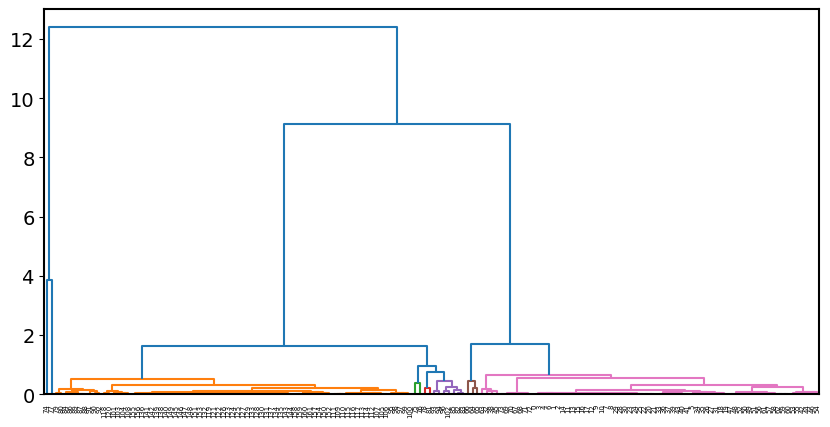

In [23]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, color_threshold=0.75)
cluster_label_test = fcluster(Z, t = 8, criterion='maxclust')

Check DTH belonging to a selected cluster

Number of ts 75
Number of events 634
Number of ev per ts 8.453333333333333


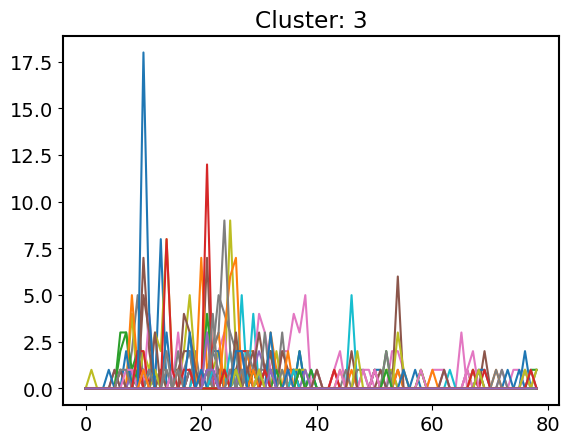

In [101]:
plotted_cluster = 3
number_ts = np.sum(cluster_label_test==plotted_cluster)
number_events = np.sum(time_series_eq_nodes[tested_key][cluster_label_test==plotted_cluster])

print(f'Number of ts {number_ts}')
print(f'Number of events {number_events}')
print(f'Number of ev per ts {number_events/number_ts}')

for series in time_series_eq_nodes[tested_key][cluster_label_test==plotted_cluster]:
    plt.plot(np.arange(len(time_series_eq_nodes[tested_key][0])), series)
    plt.title(f'Cluster: {plotted_cluster}')
plt.show()

- Add cluster column to df_catalogue

In [25]:
df_catalogue = data_catalogue.reduced_catalogue
df_density = data_catalogue.compile_dataset_days()
df_density['index_1D'] = df_density.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)

lat_max = len(data_catalogue.lat_range)
long_max = len(data_catalogue.long_range)

df_catalogue['index_1D'] = df_catalogue.apply(lambda row: index_1d(row, lat_max, long_max), axis=1)
cluster_labels = np.zeros(len(all_nodes))
cluster_labels[eq_nodes] = cluster_label_test
df_cluster_labels = pd.DataFrame(data=cluster_labels, columns=['cluster'])

df_catalogue = df_catalogue.merge(df_cluster_labels, how='left', left_on='index_1D', right_index=True)
df_density = df_density.merge(df_cluster_labels, how='left', left_on='index_1D', right_index=True)

### Graph definitions

Additional graph definitions, kept here as the form is not yet final

In [26]:
def plot_cluster_nodes(df_catalogue:pd.DataFrame, df_density:pd.DataFrame,  df_labels:pd.DataFrame, 
                       geo_bounds: dict, plotted_clusters:list = [1,2,3,4,5]) -> None:

    # Add a final element at the end of each file
    x_contour = np.arange(geo_bounds['long_min'], geo_bounds['long_max'] + geo_bounds['step_l'], geo_bounds['step_l'])
    y_contour = np.arange(geo_bounds['lat_min'], geo_bounds['lat_max'] + geo_bounds['step_l'], geo_bounds['step_l'])
    z_contour = - np.arange(geo_bounds['depth_min'], geo_bounds['depth_max'] + geo_bounds['step_d'], geo_bounds['step_d'])

    lat_range = np.arange(geo_bounds['lat_min'], geo_bounds['lat_max'] + geo_bounds['step_l'], geo_bounds['step_l'])
    long_range = np.arange(geo_bounds['long_min'], geo_bounds['long_max'] + geo_bounds['step_l'], geo_bounds['step_l'])
    depth_range = np.arange(geo_bounds['depth_min'], geo_bounds['depth_max'] + geo_bounds['step_d'], geo_bounds['step_d'])
    
    x_cat = df_catalogue['longitude']
    y_cat = df_catalogue['latitude']
    z_cat = df_catalogue['depth']

    H_cat, xedges_cat, yedges_cat = np.histogram2d(np.array(x_cat), np.array(y_cat), bins=(x_contour, y_contour))
    H_cat_depth, xedges_cat_depth, zedges_cat_depth = np.histogram2d(np.array(x_cat), -np.array(z_cat), bins=(x_contour,np.flip(z_contour)))

    X_cat, Y_cat = np.meshgrid(xedges_cat, yedges_cat)
    X_cat_depth, Z_cat_depth = np.meshgrid(xedges_cat_depth, zedges_cat_depth)

    # Setup the plot
    mpl.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=2, ncols=len(plotted_clusters), 
                             figsize=(len(plotted_clusters)*4 + 1, 9), sharey='row',)
                            #  gridspec_kw={'width_ratios': [1, 1, 1.2], "height_ratios":[1, 1.2]})
    
    # columns = ['Domain A', 'Domain B', 'Domain C']

    
    df_nodes = df_labels.copy()
    df_labels['index_1D'] = np.arange(len(df_labels))
    df_nodes = df_labels.copy()
    df_nodes['depth_id'] = df_nodes.apply(lambda row: row.index_1D // (len(lat_range)*len(long_range)), axis = 1)
    df_nodes['long_id'] = df_nodes.apply(lambda row: (row.index_1D % (len(lat_range)*len(long_range))) // len(lat_range), axis = 1)
    df_nodes['lat_id'] = df_nodes.apply(lambda row: (row.index_1D % (len(lat_range)*len(long_range))) % len(lat_range), axis = 1)

    df_nodes['depth'] = df_nodes.apply(lambda row: depth_range[int(row.depth_id)], axis=1)
    df_nodes['long'] = df_nodes.apply(lambda row: long_range[int(row.long_id)], axis=1)
    df_nodes['lat'] = df_nodes.apply(lambda row: lat_range[int(row.lat_id)], axis=1)

    lat_longs = []
    dep_longs = []

    # loop over the cluster
    for i, cl in enumerate(plotted_clusters):

        sub_df_catalogue = df_catalogue[df_catalogue.cluster == cl].copy()

        sub_df_density = df_density[df_density.cluster == cl].copy()
        sub_df_nodes = df_nodes[df_nodes.cluster == cl].copy()
        # df_nodes = sub_df_density.groupby(['index_1D'])[['lat', 'long', 'depth']].mean()
        # Node density
        # sequence_x_vals = sub_df_nodes.long
        # sequence_y_vals = sub_df_nodes.lat
        # sequence_z_vals = sub_df_nodes.depth
        # # EQ density
        sequence_x_vals = sub_df_catalogue.longitude
        sequence_y_vals = sub_df_catalogue.latitude
        sequence_z_vals = sub_df_catalogue.depth


        # Bins and contours definitions
        H, xedges, yedges = np.histogram2d(sequence_x_vals, sequence_y_vals, bins=(x_contour, y_contour))
        Hz, xedges, zedges = np.histogram2d(sequence_x_vals, -sequence_z_vals, bins=(x_contour, np.flip(z_contour)))
        H[H == 0] = 1
        Hz[Hz == 0] = 1
        X, Y = np.meshgrid(xedges, yedges)
        X1, Z = np.meshgrid(xedges, zedges)

        # Findint the highest value
        max_value_array = sub_df_density.groupby(['index_1D'])['density'].max().values
        max_value_index_array = sub_df_density.groupby(['index_1D'])['density'].max().index.to_numpy()
        max_value_index = np.argmax(max_value_array)
        max_value = np.amax(max_value_array)

        # Convert the coordinates to list
        max_value_coords = sub_df_density[sub_df_density.index_1D == max_value_index_array[max_value_index]][['lat', 'long', 'depth']].mean().to_list()
        print(f'Cluster {cl} max value: {max_value} coordinates: {max_value_coords}')


        # Lat-long graph
        axes[0, i].contour(X_cat[:-1, :-1]+(geo_bounds['step_l']), Y_cat[:-1, :-1], np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
        plot_latlong = axes[0, i].contourf(X[:-1, :-1]+(geo_bounds['step_l']), Y[:-1, :-1], np.log10(H.T), 10, cmap='Reds', vmin = 0, vmax = 6)
        lat_longs.append(plot_latlong)
        
        axes[0, i].scatter(x=max_value_coords[1]+(geo_bounds['step_l']), y=max_value_coords[0], s=100, marker='1', c='#18edd4', label = 'Max. density')

        # Visuals 
        axes[0, i].set_xlabel('Longitude')
        axes[0, i].legend(loc="lower left")
        # axes[0, i].set_xlim(-122.9, -122.7)
        # axes[0, i].set_xticks(np.arange(-122.9, -122.61, 0.05))
        # axes[0, i].set_xticklabels(["-122.9", "", "-122.8", "", "-122.7", ""])
        axes[0, i].grid(visible=True, axis='both', alpha=0.3, which='major', c='#dbdbdb')
        axes[0, i].set_title(f'{i}')
        # axes[0, i].set_clim(0, 6)


        # Depth-long graph
        axes[1, i].contour(X_cat_depth[:-1, :-1]+(geo_bounds['step_l']), Z_cat_depth[:-1, :-1]+(geo_bounds['step_d']), np.log10(H_cat_depth.T), 15,
                           cmap='Greys')
        plot_longdepth = axes[1, i].contourf(X1[:-1, :-1]+(geo_bounds['step_l']), Z[:-1, :-1]+(geo_bounds['step_d']), np.log10(Hz.T), 10, cmap='Reds', vmin = 0, vmax = 6)
        dep_longs.append(plot_longdepth)
        axes[1, i].scatter(x=max_value_coords[1]+(geo_bounds['step_l']), y=-(max_value_coords[2]-(geo_bounds['step_d']/2)), s=100, marker='1', c='#18edd4', label = 'Max. density')

        # Visuals 
        axes[1, i].set_xlabel('Longitude')
        # axes[1, i].set_xlim(-122.9, -122.65)
        # axes[1, i].set_xticks(np.arange(-122.9, -122.61, 0.05))
        # axes[1, i].set_xticklabels(["-122.9", "", "-122.8", "", "-122.7", ""])
        axes[1, i].grid(visible=True, axis='both', alpha=0.3, which='major', c='#dbdbdb')

    fig.colorbar(lat_longs[0], ax=axes[0, i], label='Eq. density [log10]')
    fig.colorbar(dep_longs[0], ax=axes[1, i], label='Eq. density [log10]')

    # Ax settings
    axes[0, 0].set_ylabel('Latitude')
    # axes[0, 0].set_ylim(38.7, 38.9)
    # axes[0, 0].set_yticks(np.arange(38.7, 38.91, 0.05))
    # axes[0, 0].set_yticklabels(["38.7", "", "38.8", "", "38.9"])

    axes[1, 0].set_ylabel('Depth [km]')
    # axes[1, 0].set_ylim(-10, 0)
    # axes[1, 0].set_yticks(np.arange(-10, 1, 1))
    # axes[1, 0].set_yticklabels(["-10","", "-8", "", "-6", "", "-4", "", "-2", "", "0"])

    # Final settings
    plt.tight_layout()
    plt.show()

    return

C:\Users\macie\AppData\Local\Temp\ipykernel_21824\4248975810.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  ratios_coulomb_stress_max.append(np.log(ref_max_N_eq)/np.log(max_time_histories))
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\4248975810.py:49: RuntimeWarning: divide by zero encountered in log
  ratios_coulomb_stress_max.append(np.log(ref_max_N_eq)/np.log(max_time_histories))
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\4248975810.py:51: RuntimeWarning: divide by zero encountered in divide
  delta_P_x_short_time = (flux_injection/(4*np.pi*diff_coeff[0]*nodes_distances)) * erfc(nodes_distances / (2 * np.sqrt(diff_coeff [0] * times_for_diff_equation)))
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\4248975810.py:52: RuntimeWarning: divide by zero encountered in divide
  delta_P_x_long_time = (flux_injection/(4*np.pi*diff_coeff[1]*nodes_distances)) * erfc(nodes_distances / (2 * np.sqrt(diff_coeff [1] * times_for_diff_equation)))
C:\Users\macie\A

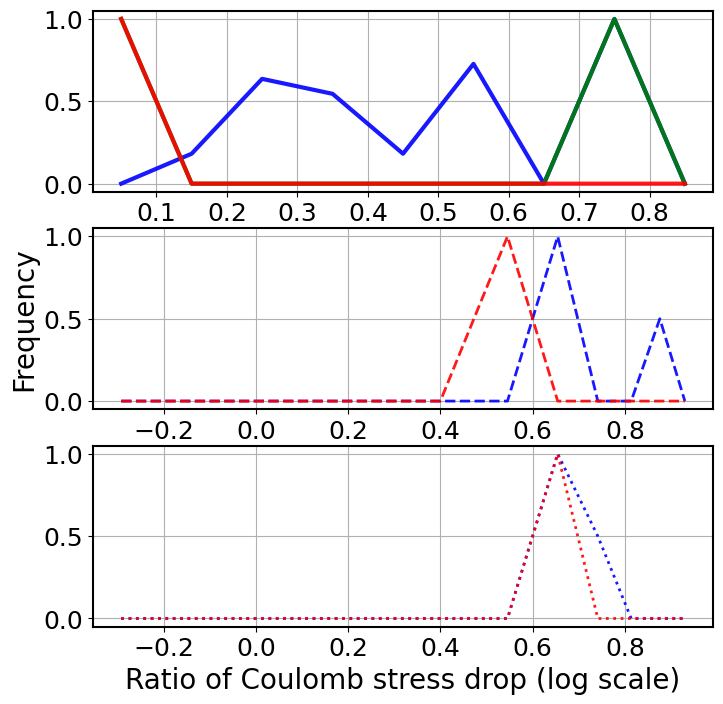

In [113]:
# Coulomb stress ratio graph from Mauro

from scipy.special import erfc

flux_injection = 10
diff_coeff = [1, 10]
times_for_diff_equation=86400*30

nodes = eq_nodes.copy()
df_position_helper = df_density.groupby(['index_1D'])[['lat', 'long', 'depth', 'cluster']].mean()
longs_nodes = df_position_helper.lat.to_list()
lats_nodes = df_position_helper.long.to_list()
depths_nodes = df_position_helper.depth.to_list()
cluster_nodes = df_position_helper.cluster.to_list()
max_eqs_nodes = np.max(time_series_eq_nodes['30d'], axis = 1)

df_summary_file = df_density.copy()

x_nodes = np.array(longs_nodes) * 111.320 * np.cos(2 * np.array(lats_nodes) / np.pi)
y_nodes = np.array(lats_nodes) * 110.574


ind_max_dth_domain_a = np.argmax(max_eqs_nodes [np.array(cluster_nodes[:-1]) == 5])
ind_max_dth_domain_b = np.argmax(max_eqs_nodes [np.array(cluster_nodes[:-1]) == 4])
ind_max_dth_domain_c = np.argmax(max_eqs_nodes [np.array(cluster_nodes[:-1]) == 3])

x_ref = np.array(x_nodes)[np.array(cluster_nodes) == 5][ind_max_dth_domain_a]
y_ref = np.array(y_nodes)[np.array(cluster_nodes) == 5][ind_max_dth_domain_a]
z_ref = np.array(depths_nodes) [np.array(cluster_nodes) == 5][ind_max_dth_domain_a] * 1000

delta_x_ref_ic2 = x_nodes - x_ref
delta_y_ref_ic2 = y_nodes - y_ref
delta_z_ref_ic2 = np.array(depths_nodes)*1000 - z_ref

nodes_distances = np.sqrt(delta_x_ref_ic2**2 + delta_y_ref_ic2**2 + delta_z_ref_ic2**2)

nodes_cluster_3 = np.array(np.unique(df_summary_file[df_summary_file.cluster==3]['index_1D']))
nodes_cluster_4 = np.array(np.unique(df_summary_file[df_summary_file.cluster==4]['index_1D']))
nodes_cluster_5 = np.array(np.unique(df_summary_file[df_summary_file.cluster==5]['index_1D']))

indices_nodes_cluster_3 = np.arange(len(nodes))[np.isin(nodes, nodes_cluster_3)]
indices_nodes_cluster_4 = np.arange(len(nodes))[np.isin(nodes, nodes_cluster_4)]
indices_nodes_cluster_5 = np.arange(len(nodes))[np.isin(nodes, nodes_cluster_5)]

ref_max_N_eq = max_eqs_nodes[indices_nodes_cluster_5[ind_max_dth_domain_a]]

ratios_coulomb_stress_max = []
for en_index_node, (index_node, max_time_histories) in enumerate(zip(nodes, max_eqs_nodes)):
        ratios_coulomb_stress_max.append(np.log(ref_max_N_eq)/np.log(max_time_histories))

delta_P_x_short_time = (flux_injection/(4*np.pi*diff_coeff[0]*nodes_distances)) * erfc(nodes_distances / (2 * np.sqrt(diff_coeff [0] * times_for_diff_equation)))
delta_P_x_long_time = (flux_injection/(4*np.pi*diff_coeff[1]*nodes_distances)) * erfc(nodes_distances / (2 * np.sqrt(diff_coeff [1] * times_for_diff_equation)))

hist_diff_model_cl_3, bin_edges_diff_model = np.histogram(np.log10(1/delta_P_x_short_time)[indices_nodes_cluster_3], np.arange(0.01, 10.01, 1))
hist_diff_model_cl_4, bin_edges_diff_model = np.histogram(np.log10(1/delta_P_x_short_time)[indices_nodes_cluster_4], np.arange(0.01, 10.01, 1))
hist_diff_model_cl_5, bin_edges_diff_model = np.histogram(np.log10(1/delta_P_x_short_time)[indices_nodes_cluster_5], np.arange(0.01, 10.01, 1))

hist_diff_model_cl_3_long, bin_edges_diff_model = np.histogram(
        np.log10(1 / delta_P_x_long_time)[indices_nodes_cluster_3], np.arange(0.01, 10.01, 1))
hist_diff_model_cl_4_long, bin_edges_diff_model = np.histogram(
        np.log10(1 / delta_P_x_long_time)[indices_nodes_cluster_4], np.arange(0.01, 10.01, 1))
hist_diff_model_cl_5_long, bin_edges_diff_model = np.histogram(
        np.log10(1 / delta_P_x_long_time)[indices_nodes_cluster_5], np.arange(0.01, 10.01, 1))

hist_diff_model_all, bin_edges_diff_model = np.histogram(np.log10(1/delta_P_x_short_time), np.arange(0.01, 10, 1))
hist_diff_model_all_long, bin_edges_diff_model = np.histogram(np.log10(1/delta_P_x_long_time), np.arange(0.01, 10, 1))

hist_cl_3_ratios_max, bin_edges_ratios_max = np.histogram(np.log10(ratios_coulomb_stress_max)[indices_nodes_cluster_3], np.arange(0, 1, 0.1))
hist_cl_4_ratios_max, bin_edges_ratios_max = np.histogram(np.log10(ratios_coulomb_stress_max)[indices_nodes_cluster_4], np.arange(0, 1, 0.1))
hist_cl_5_ratios_max, bin_edges_ratios_max = np.histogram(np.log10(ratios_coulomb_stress_max)[indices_nodes_cluster_5], np.arange(0, 1, 0.1))

plt.figure(figsize = (8, 8))
plt.subplot(3,1,1)
plt.plot(bin_edges_ratios_max[:-1]+0.05, hist_cl_3_ratios_max/max(hist_cl_3_ratios_max), label='Cluster C', alpha = 0.9, c='b', linewidth = 3)
plt.plot(bin_edges_ratios_max[:-1]+0.05, hist_cl_4_ratios_max/max(hist_cl_4_ratios_max), label='Cluster B', alpha = 0.9, c='g', linewidth = 3)
plt.plot(bin_edges_ratios_max[:-1]+0.05, hist_cl_5_ratios_max/max(hist_cl_5_ratios_max), label='Cluster A', alpha = 0.9, c='r', linewidth = 3)
# plt.text(-0.05,0.8,'(a)',fontsize=18)
# plt.legend(prop={'size': 16})
# plt.xticks([0, 0.3, 0.6, .78,1], (['', '2', '4', '6', '10']))
# plt.xlim([-.1,1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(np.log10(bin_edges_diff_model[:-1]+0.5), hist_diff_model_cl_3/max(hist_diff_model_cl_3), 'b--', alpha = 0.9, linewidth = 2)
plt.plot(np.log10(bin_edges_diff_model[:-1]+0.5), hist_diff_model_cl_4/max(hist_diff_model_cl_4), 'g--', alpha = 0.9, linewidth = 2)
plt.plot(np.log10(bin_edges_diff_model[:-1]+0.5), hist_diff_model_cl_5/max(hist_diff_model_cl_5), 'r--', alpha = 0.9, linewidth = 2)
# plt.text(-0.05,0.8,'(b)',fontsize=18)
# plt.ylabel('Frequency', fontsize=24)
# plt.xticks([0, 0.3, 0.6, .78,1], (['', '2', '4', '6', '10']))
# plt.xlim([-0.1, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Frequency', fontsize=20)

plt.grid()

plt.subplot(3,1,3)
# plt.text(-0.05,0.8,'(c)',fontsize=18)
plt.plot(np.log10(bin_edges_diff_model[:-1] + 0.5), hist_diff_model_cl_3_long / max(hist_diff_model_cl_3_long), 'b:',
             alpha=0.9, linewidth=2)
plt.plot(np.log10(bin_edges_diff_model[:-1] + 0.5), hist_diff_model_cl_4_long / max(hist_diff_model_cl_4_long), 'g:',
             alpha=0.9, linewidth=2)
plt.plot(np.log10(bin_edges_diff_model[:-1] + 0.5), hist_diff_model_cl_5_long / max(hist_diff_model_cl_5_long), 'r:',
             alpha=0.9, linewidth=2)
# plt.xticks([0, 0.3, 0.6, .78,1], (['', '2', '4', '6', '10']))
# plt.xlim([-.1,1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

plt.xlabel('Ratio of Coulomb stress drop (log scale)', fontsize = 20)

plt.show()

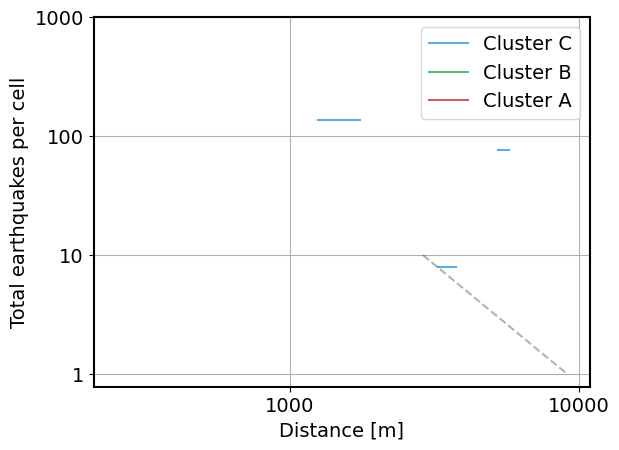

In [127]:
# Number of EQ as a function of distance from max point graph from Mauro
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

colors = ['#5DADE2', '#52BE80', '#CD6155']
names = ['C','B','A']
plotted_clusters = [3, 4, 5]
dist_max_hist_eq_dist = 15000
step_hist_eq_dist = 500
cumsum_eqs_nodes = np.sum(time_series_eq_nodes['30d'], axis = 1)

hist_nodes_all_cl = []
for cl in plotted_clusters:
    hist_nodes = []
    for nodes_dist in np.arange(0, dist_max_hist_eq_dist, step_hist_eq_dist):
        # means_one_cl = mean_eqs_nodes [cluster_nodes==cl]
        hist_nodes.append(np.mean(np.array(cumsum_eqs_nodes) [(np.array(cluster_nodes[:-1])==cl) & (nodes_distances[:-1]>=nodes_dist) & (nodes_distances[:-1]<nodes_dist+1000)]))
    hist_nodes_all_cl.append(hist_nodes)

fig, ax = plt.subplots()
for i, hists_cl  in enumerate(hist_nodes_all_cl):
    plt.plot(np.log10(np.arange(0, dist_max_hist_eq_dist, step_hist_eq_dist)+step_hist_eq_dist/2), np.log10(hists_cl), c=colors[i], label=f'Cluster {names[i]}')
plt.plot(np.array([3.5,4])-.04,[1,0],'k--', alpha = 0.3)

plt.xlabel('Distance [m]')
plt.ylabel('Total earthquakes per cell')
plt.xticks([3, 4], (['1000', '10000']))
plt.yticks([0,1, 2,3], (['1','10', '100', '1000']))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.grid(which='both', axis='both')
ax.tick_params(axis='both', which='major')
plt.legend()

### Other


In [27]:
df_density['lat'] = data_catalogue.lat_range[df_density.loc[:, 'lat_id'].values]
df_density['long'] = data_catalogue.long_range[df_density.loc[:, 'long_id'].values]
df_density['depth'] = data_catalogue.depth_range[df_density.loc[:, 'depth_id'].values]

df_catalogue = df_catalogue.rename(columns={'Depthkm' : 'Depth'})

In [42]:
geo_bounds_plot = {'lat_min': -0,
            'lat_max': 1500,
            'long_min': -1000,
            'long_max': 1000,
            'depth_min': 1800,
            'depth_max': 2200,
            'step_l': 100,
            'step_d': 25}

Cluster 1 max value: 600 coordinates: [400.0, 0.0, 1900.0]
Cluster 2 max value: 375 coordinates: [1000.0, 0.0, 1900.0]
Cluster 3 max value: 22 coordinates: [400.0, 600.0, 2100.0]


C:\Users\macie\AppData\Local\Temp\ipykernel_21824\3789518358.py:84: RuntimeWarning: divide by zero encountered in log10
  axes[0, i].contour(X_cat[:-1, :-1]+(geo_bounds['step_l']), Y_cat[:-1, :-1], np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\3789518358.py:102: RuntimeWarning: divide by zero encountered in log10
  axes[1, i].contour(X_cat_depth[:-1, :-1]+(geo_bounds['step_l']), Z_cat_depth[:-1, :-1]+(geo_bounds['step_d']), np.log10(H_cat_depth.T), 15,
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\3789518358.py:84: RuntimeWarning: divide by zero encountered in log10
  axes[0, i].contour(X_cat[:-1, :-1]+(geo_bounds['step_l']), Y_cat[:-1, :-1], np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
C:\Users\macie\AppData\Local\Temp\ipykernel_21824\3789518358.py:102: RuntimeWarning: divide by zero encountered in log10
  axes[1, i].contour(X_cat_depth[:-1, :-1]+(geo_bounds['step_l']), Z_cat_depth[:-1, :-1]+(geo_bounds['step_d']), np.log1

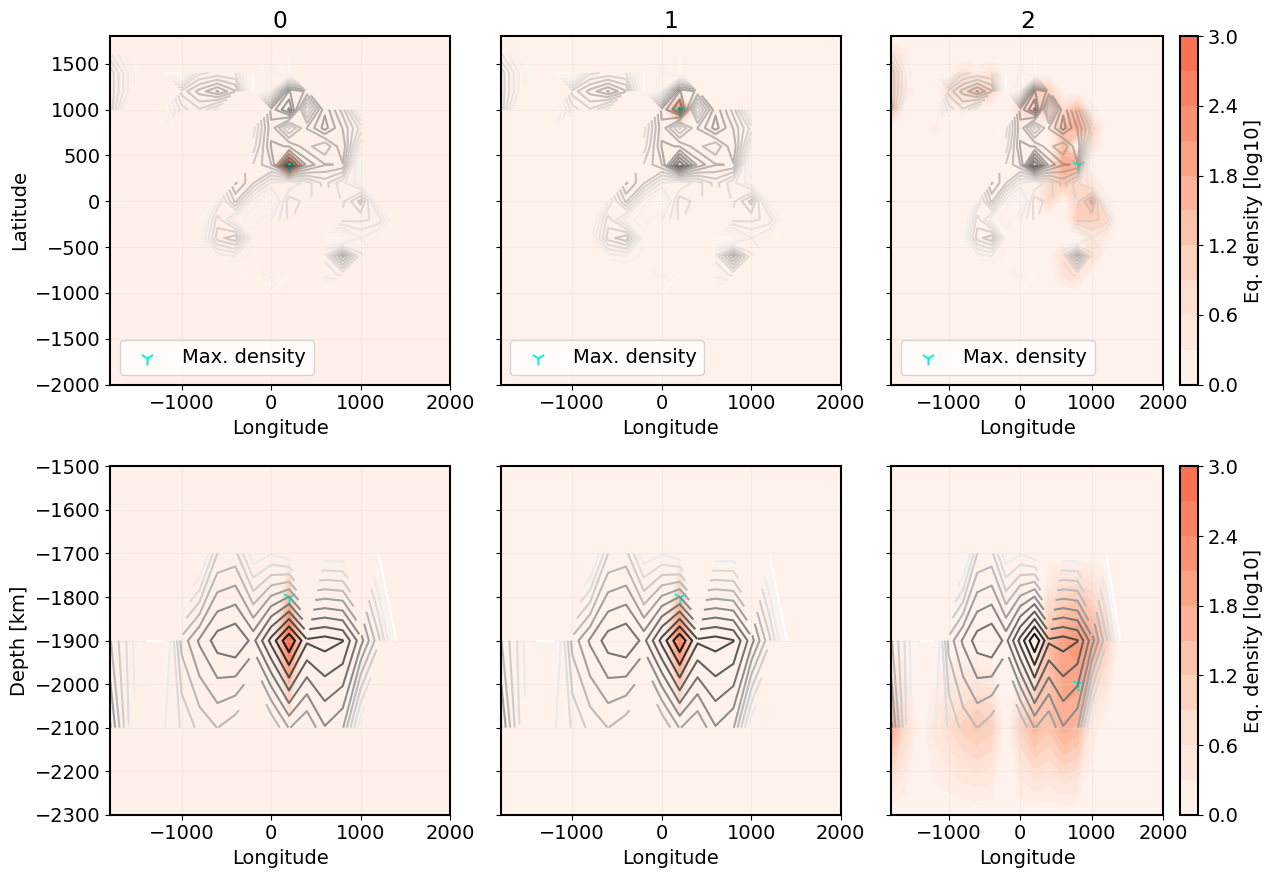

In [41]:
plot_cluster_nodes(df_catalogue=df_catalogue, df_density=df_density, df_labels=df_cluster_labels, geo_bounds=geo_bounds, plotted_clusters=[1, 2, 3])

In [29]:
df_catalogue_time_sorted = df_catalogue.sort_values(by='event_time')
df_catalogue_time_sorted['IET'] = (df_catalogue_time_sorted.event_time - df_catalogue_time_sorted.event_time.shift(1))

In [30]:
df_catalogue_time_sorted['IET_seconds'] = df_catalogue_time_sorted.apply(lambda row: row['IET'].total_seconds(), axis = 1)
df_catalogue_time_sorted['IET_seconds_log10'] = np.log10(df_catalogue_time_sorted['IET_seconds'])
df_catalogue_time_sorted = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] > 0]

In [31]:
df_catalogue_time_sorted.dropna(subset='IET', inplace=True)

In [32]:
df_cv = df_catalogue_time_sorted.groupby('cluster')['IET_seconds'].agg(['mean', 'std'])
df_cv['cv'] = df_cv['std'] / df_cv['mean']
df_cv

,mean,std,cv
cluster,,,
1.0,17924.244728,88643.065812,4.945428
2.0,7555.600331,24134.088833,3.194199
3.0,88849.665002,193738.025412,2.180515
4.0,73061.581355,188708.096528,2.582864
5.0,40160.865954,149390.055661,3.719792
6.0,63315.471495,179488.704345,2.834832
7.0,33701.779533,212616.976064,6.308776
8.0,89148.776740,214174.224390,2.402436


### Graphs

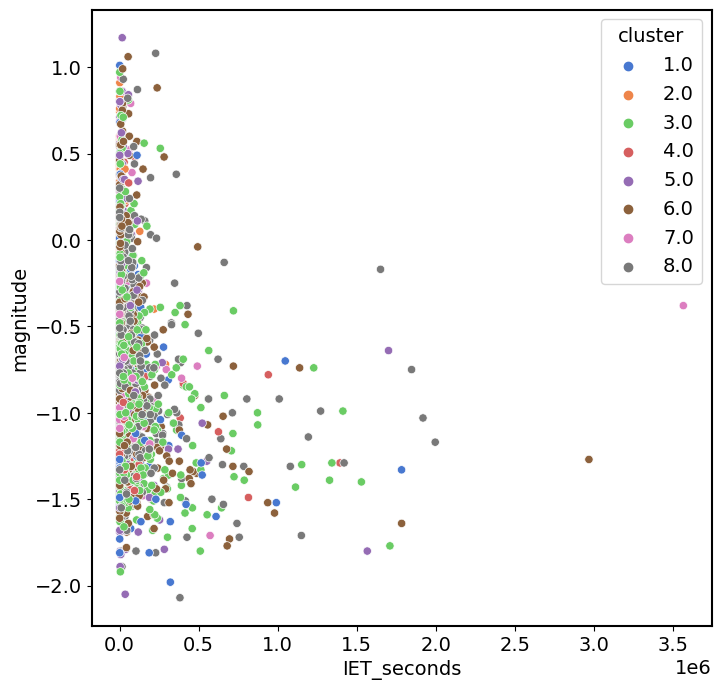

In [33]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'IET_seconds', y = 'magnitude', hue = 'cluster', palette='muted', )
plt.show()

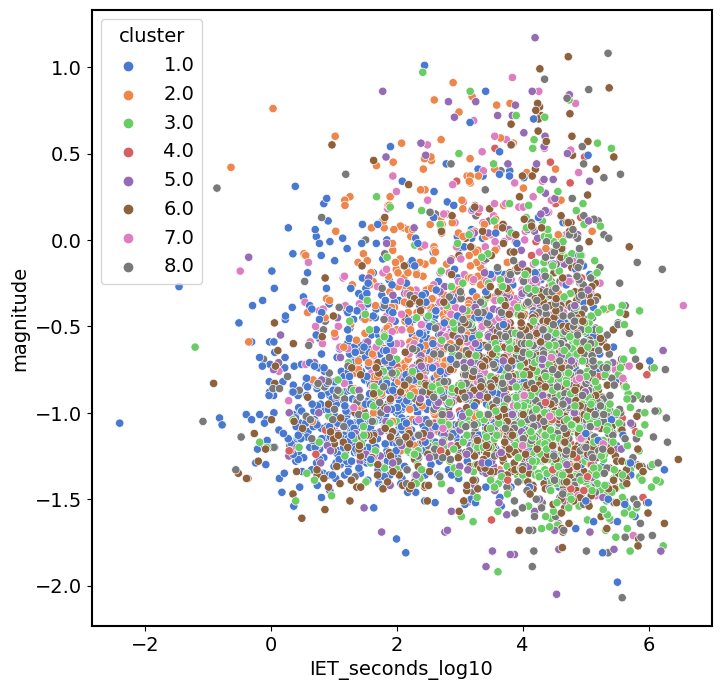

In [34]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'IET_seconds_log10', y = 'magnitude', hue = 'cluster', palette='muted', )
plt.show()

In [35]:
def distance_from_inj(row):
    x = row['longitude']
    y = row['latitude']
    z = 2140 - row['depth']

    distance = np.array([x, y, z])

    return np.sqrt(distance.dot(distance))


df_catalogue_time_sorted['dist_from_inj_m'] = df_catalogue.apply(lambda row: distance_from_inj(row), axis = 1)

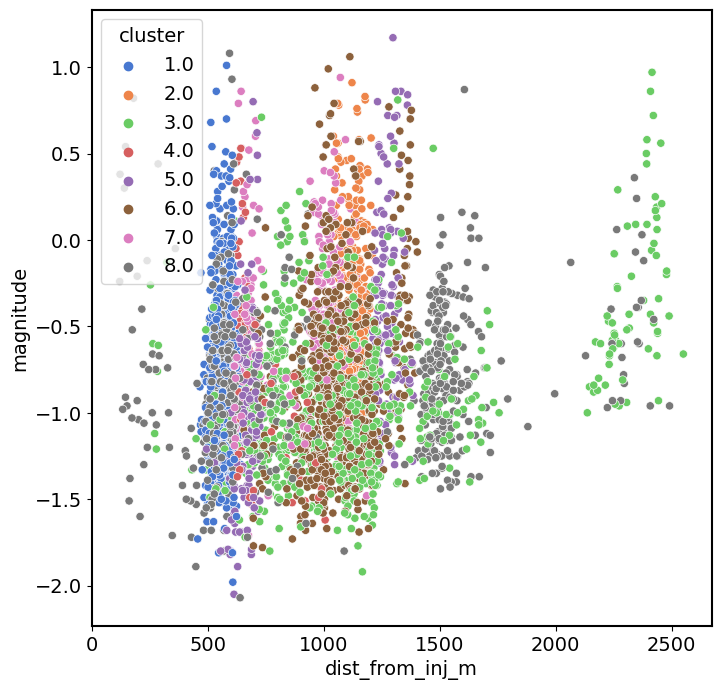

In [36]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'dist_from_inj_m', y = 'magnitude', hue = 'cluster', palette='muted')
plt.show()

In [37]:
event_time_start = df_catalogue_time_sorted['event_time'].min()

df_catalogue_time_sorted['event_time_seconds'] = df_catalogue_time_sorted.apply(lambda row: (row['event_time']-event_time_start).total_seconds(), axis = 1)

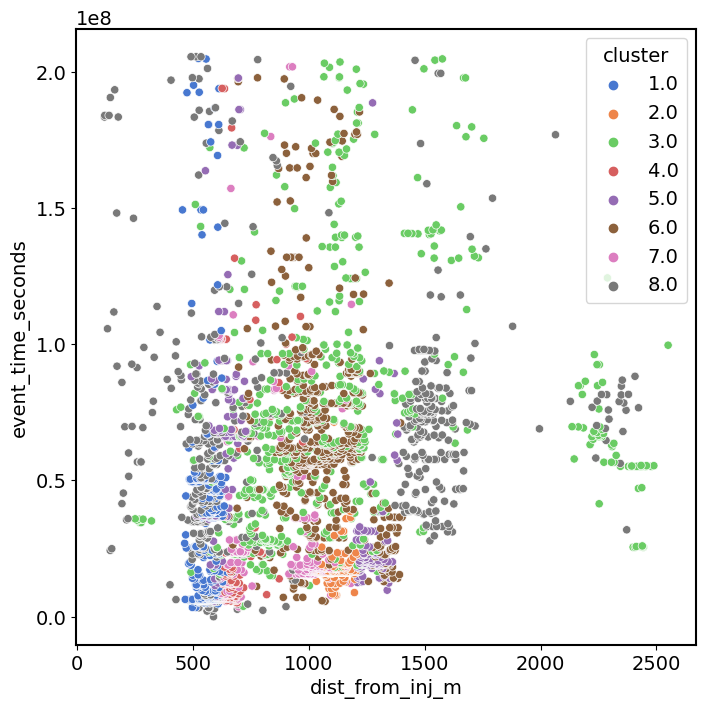

In [38]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'dist_from_inj_m', y = 'event_time_seconds', hue = 'cluster', palette='muted', )
plt.show()

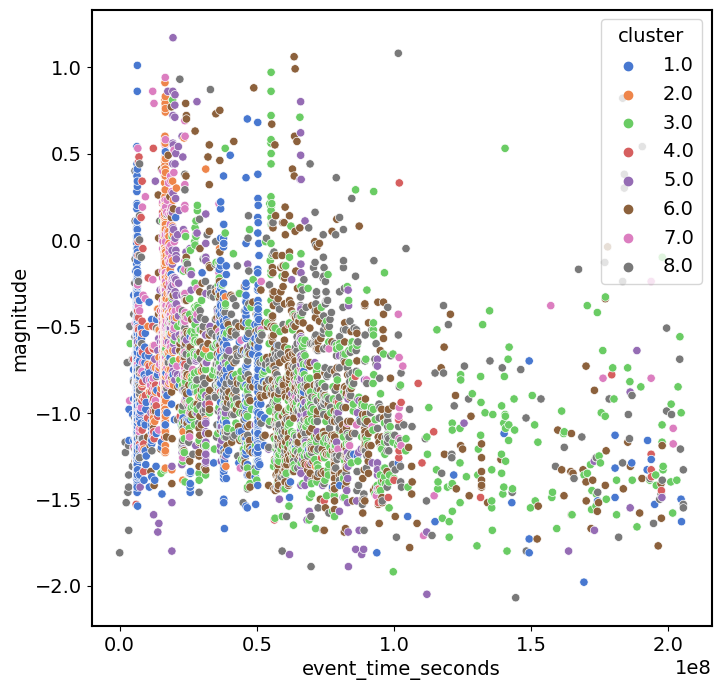

In [39]:
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(data=df_catalogue_time_sorted, x = 'event_time_seconds', y = 'magnitude', hue = 'cluster', palette='muted', )
plt.show()

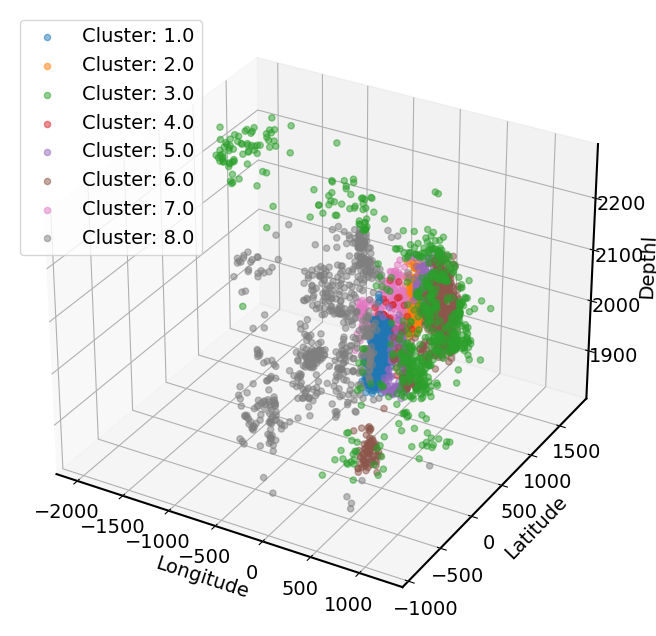

In [40]:
import matplotlib as mpl
mpl.interactive = True

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

for cluster in np.sort(np.unique(df_catalogue_time_sorted['cluster'].values)):
    
    xs = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['longitude'].values
    ys = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['latitude'].values
    zs = df_catalogue_time_sorted[df_catalogue_time_sorted['cluster'] == cluster]['depth'].values
    ax.scatter(xs, ys, zs, label = f'Cluster: {cluster}', alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depthl')
plt.legend()
plt.show()